In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
# import Kmeans from sklearn
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage
from scipy.stats import wasserstein_distance, binned_statistic

import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *

In [2]:
df = pd.read_csv(os.path.join(ppath, 'data', 'uciml_pima-indians-diabetes-database', 'diabetes.csv'))
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [58]:
age = list(df['Age'])
N = len(age)
bins0 = [0, 19, 45, 65, 85, 100]
bins1 = [0, 10, 20, 35, 40, 50, 60, 70, 80, 90, 100]
bins2 = [0, 20, 40, 60, 80, 100]
bins3 = [0, 18, 45, 60, 80, 100]
binning = [bins0, bins1, bins2, bins3]

Explore if the distance measure makes sense if we encode partitioned age data using distribution

In [65]:
ls = []
for bins in binning:
    hist, bin_edges = np.histogram(age, bins=bins)
    distribution = hist / N
    print(distribution)

    medians, _, _ = binned_statistic(age, age, bins=bins, statistic='median')
    medians[np.isnan(medians)] = 0
    ls.append((medians, distribution))

[0.         0.82682292 0.15234375 0.02083333 0.        ]
[0.         0.         0.63541667 0.09505208 0.15364583 0.07421875
 0.03776042 0.00260417 0.00130208 0.        ]
[0.         0.73046875 0.22786458 0.04036458 0.00130208]
[0.         0.82682292 0.13151042 0.04036458 0.00130208]


In [76]:
d = wasserstein_distance(ls[0][1], ls[1][1])
print(d)

0.1036458333333333


In [81]:
i = 1
j = 2
print(ls[i][0], ls[j][0])
d = wasserstein_distance(ls[i][1], ls[j][1],ls[i][0], ls[j][0])
print(d)

[ 0.  0. 25. 37. 43. 53. 63. 71. 81.  0.] [ 0. 26. 45. 64. 81.]
0.0672509686434647


In [74]:
def binarize(a):
    return np.where(a>0, 1, 0).astype(float)

In [84]:
i = 1
j = 2
print(binarize(ls[i][0]))
print(binarize(ls[j][0]))
d = wasserstein_distance(ls[i][1], ls[j][1],binarize(ls[i][0]), binarize(ls[j][0]))
print(d)

[0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[0. 1. 1. 1. 1.]
0.1122581845238095


Explore if the distance measure makes sense if we **directly** use the partitioned age data

In [35]:
ls = []
for bins in binning:
    x = pd.cut(age, bins=bins, labels=bins[1:])
    x = x.astype('float64')
    #print(x)

    
    ls.append(x)

In [36]:
np.linalg.norm(ls[0] - ls[2])

193.39079605813717

In [32]:
np.linalg.norm(ls[0] - ls[3])

77.13624310270757

In [37]:
np.linalg.norm(ls[0] - ls[1])

257.1964229922337

In [38]:
np.linalg.norm(ls[1] - ls[2])

162.32683080747927

In [31]:
np.linalg.norm(ls[3] - ls[2])

177.341478509682

In [3]:
import json
import ast
f = open(os.path.join(ppath, 'scratch/age_partitions.json'), "r")
data = json.load(f)
f.close()
binnings = list(eval(data))
col = 'Age'
outs = []
age = list(df['Age'])
N = len(age)

data = df.copy()
data['Age.gt'] = data['Age']
df_nan = df.sample(frac=0.3, random_state=42)
data.loc[df.index.isin(df_nan.index),'Age'] = np.nan

for i in binnings:
    #bins = i
    #semantic = 0
    bins = i['bins']
    semantic = i['gpt']
    data_i = data.copy()
    data_i[col + '.binned'] = pd.cut(data_i[col], bins=bins, labels=bins[1:])
    #data_i[col + '.binned'] = data_i[col + '.binned'].astype('float64')

    imputer = KNNImputer(n_neighbors=len(bins)-1)
    data_imputed = imputer.fit_transform(data_i[col + '.binned'].values.reshape(-1, 1))
    data_imputed = np.round(data_imputed)
    data_i['Age.imputed'] = data_imputed
    data_i[col + '.final'] = pd.cut(data_i[col+'.imputed'], bins=bins, labels=bins[1:])
    data_i[col + '.final'] = data_i[col + '.final'].astype('float64')

    if len(data_i[data_i[col + '.final'].isnull()]) > 200:
        print(f"Skipping {bins}")
        continue
    #data_i['Age.final'] = data_i['Age.final'].fillna(-1)
    value_final = np.array(data_i['Age.final'].values)
    value_final[np.isnan(value_final)] = -1

    # Evaluate data imputation
    data_i['Age.gt'] = pd.cut(data_i['Age.gt'], bins=bins, labels=bins[1:])
    data_i['Age.gt'] = data_i['Age.gt'].astype('float64')
    value_gt = np.array(data_i['Age.gt'].values)
    value_gt[np.isnan(value_gt)] = -1
    #data_i['Age.gt'] = data_i['Age.gt'].fillna(-1)
    #data_i = data_i.dropna(subset=['Age.final', 'Age.gt'])
    impute_accuracy = accuracy_score(value_gt, value_final)

    #print(f"{bins}:", 1-i['gpt'], impute_accuracy)

    hist, bin_edges = np.histogram(age, bins=bins)
    distribution = hist / N

    outs.append({'bins': bins, 'distribution': distribution, 'partitioned': np.array(data_i[col + '.final']), 'gpt': 1-semantic, 'impute_accuracy': impute_accuracy})

print(outs[0])
# dictionary to dataframe
#df_out = pd.DataFrame(outs)
#df_out

{'bins': [0, 19, 45, 65, 85, 100], 'distribution': array([0.        , 0.82682292, 0.15234375, 0.02083333, 0.        ]), 'partitioned': array([65., 45., 65., 45., 45., 45., 65., 65., 65., 65., 65., 45., 65.,
       65., 65., 45., 45., 45., 45., 45., 45., 65., 45., 65., 65., 45.,
       45., 45., 65., 45., 65., 65., 45., 65., 45., 45., 45., 65., 45.,
       65., 45., 65., 65., 65., 65., 45., 45., 45., 45., 65., 45., 65.,
       45., 65., 65., 65., 65., 45., 45., 45., 65., 45., 45., 65., 45.,
       65., 65., 65., 45., 65., 65., 45., 65., 65., 45., 45., 65., 65.,
       65., 65., 45., 65., 65., 45., 65., 45., 65., 45., 45., 45., 65.,
       45., 45., 65., 45., 45., 45., 65., 45., 45., 45., 65., 45., 45.,
       45., 45., 45., 45., 65., 65., 65., 65., 45., 45., 45., 65., 45.,
       45., 65., 45., 65., 45., 45., 85., 45., 45., 45., 45., 45., 65.,
       45., 65., 65., 65., 45., 65., 65., 65., 45., 45., 65., 45., 45.,
       45., 45., 65., 45., 45., 65., 45., 45., 45., 45., 45., 45., 65.,
 

In [92]:
# dictionary to dataframe
df_out = pd.DataFrame(outs)
# get partitioned data as a two dimensional array
partitioned = np.array(df_out['partitioned'].values.tolist())
# run Kmeans clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(partitioned)
# get cluster labels, and add to the dataframe
df_out['cluster'] = kmeans.labels_
# print the cluster centers
print(kmeans.cluster_centers_)

[[61.66666667 41.66666667 61.66666667 ... 41.66666667 61.66666667
  41.66666667]
 [54.125      40.625      41.75       ... 30.         51.625
  24.75      ]
 [59.33333333 55.33333333 59.33333333 ... 35.66666667 59.33333333
  28.        ]
 [57.         33.77777778 36.88888889 ... 32.44444444 56.77777778
  23.88888889]
 [57.5        57.5        57.5        ... 57.5        57.5
  25.        ]]


In [24]:
# dictionary to dataframe
df_out = pd.DataFrame(outs)
# get partitioned data as a two dimensional array
partitioned = np.array(df_out['partitioned'].values.tolist())
# bin impute accuracy
#df_out['truth'] = pd.cut(df_out['impute_accuracy'], bins=[0, 0.7, 0.75, 0.8, 0.85, 0.9], labels=['0-0.7', '0.7-0.75', '0.75-0.8', '0.8-0.85', '0.85-0.9'])
df_out

,bins,distribution,partitioned,gpt,impute_accuracy
0,"[0, 19, 45, 65, 85, 100]","[0.0, 0.8268229166666666, 0.15234375, 0.020833...","[65.0, 45.0, 65.0, 45.0, 45.0, 45.0, 65.0, 65....",1.0,0.747396
1,"[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.0, 32.0, 34.0, 22.0, 34.0, 30.0, 34.0, 34....",0.0,0.713542
2,"[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55,...","[0.0, 0.0, 0.0, 0.0, 0.28515625, 0.23046875, 0...","[50.0, 35.0, 35.0, 25.0, 35.0, 30.0, 35.0, 35....",0.8,0.730469
3,"[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]","[0.0, 0.0, 0.515625, 0.21484375, 0.15364583333...","[50.0, 40.0, 40.0, 30.0, 40.0, 30.0, 40.0, 40....",0.8,0.761719
4,"[0, 20, 40, 60, 80, 100]","[0.0, 0.73046875, 0.22786458333333334, 0.04036...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.9,0.765625
5,"[0, 25, 50, 75, 100]","[0.28515625, 0.5989583333333334, 0.11458333333...","[50.0, 50.0, 50.0, 25.0, 50.0, 50.0, 50.0, 50....",0.7,0.863281
6,"[0, 30, 60, 90]","[0.515625, 0.4427083333333333, 0.0416666666666...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.4,0.826823
7,"[0, 15, 25, 65, 101]","[0.0, 0.28515625, 0.6940104166666666, 0.020833...","[65.0, 65.0, 65.0, 25.0, 65.0, 65.0, 65.0, 65....",0.7,0.898438
8,"[0, 3, 40, 60, 101]","[0.0, 0.73046875, 0.22786458333333334, 0.04166...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.3,0.765625
9,"[0, 10, 30, 60, 80, 101]","[0.0, 0.515625, 0.4427083333333333, 0.04036458...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.7,0.826823


In [37]:
# dictionary to dataframe
df_out = pd.DataFrame(outs)
# get partitioned data as a two dimensional array
partitioned = np.array(df_out['partitioned'].values.tolist())
datapoints = np.array([np.array(df_out['gpt']), np.array(df_out['impute_accuracy'])])
datapoints

array([[1.        , 0.        , 0.8       , 0.8       , 0.9       ,
        0.7       , 0.4       , 0.7       , 0.3       , 0.7       ,
        0.2       , 0.1       , 0.2       , 0.2       , 0.2       ,
        0.2       , 0.1       , 0.1       , 0.2       , 0.2       ,
        0.1       , 0.2       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.3       ],
       [0.74739583, 0.71354167, 0.73046875, 0.76171875, 0.765625  ,
        0.86328125, 0.82682292, 0.8984375 , 0.765625  , 0.82682292,
        0.8046875 , 0.73697917, 0.76692708, 0.73697917, 0.73958333,
        0.69010417, 0.72916667, 0.69010417, 0.71223958, 0.69010417,
        0.7109375 , 0.69010417, 0.7109375 , 0.69010417, 0.70442708,
        0.69010417, 0.70442708, 0.66927083]])

In [38]:
pareto=oapackage.ParetoDoubleLong()

for ii in range(0, datapoints.shape[1]):
    w=oapackage.doubleVector( (datapoints[0,ii], datapoints[1,ii]))
    pareto.addvalue(w, ii)

pareto.show(verbose=1)

Pareto: 3 optimal values, 3 objects


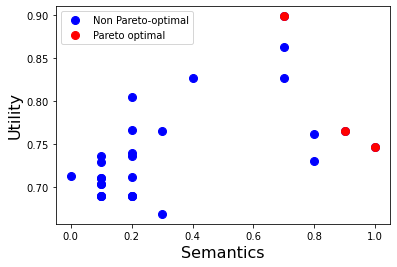

In [39]:
lst=pareto.allindices() # the indices of the Pareto optimal designs

optimal_datapoints=datapoints[:,lst]

h=plt.plot(datapoints[0,:], datapoints[1,:], '.b', markersize=16, label='Non Pareto-optimal')
hp=plt.plot(optimal_datapoints[0,:], optimal_datapoints[1,:], '.r', markersize=16, label='Pareto optimal')
plt.xlabel('Semantics', fontsize=16)
plt.ylabel('Utility', fontsize=16)
#plt.xticks([])
#plt.yticks([])
_=plt.legend(loc=0, numpoints=1)

In [40]:
# label the Pareto optimal points in the dataframe as 1; otherwise 0
df_out['pareto'] = 0
df_out.loc[lst, 'pareto'] = 1
# dataframe to json file
#df_out.to_json(os.path.join(ppath, 'scratch', 'age_partitions.pareto.20240725.json'), orient='records')

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)
X = list(df_out['partitioned'].values)
processed = pca.fit_transform(X)

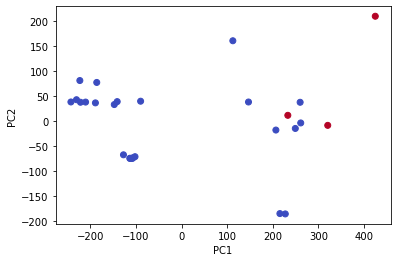

In [26]:
pcadf = pd.DataFrame( data = processed, columns = ['PC1', 'PC2'])
pcadf['pareto'] = df_out['pareto']
# plot the PCA, with Pareto optimal points in red
plt.scatter(pcadf['PC1'], pcadf['PC2'], c=pcadf['pareto'], cmap='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

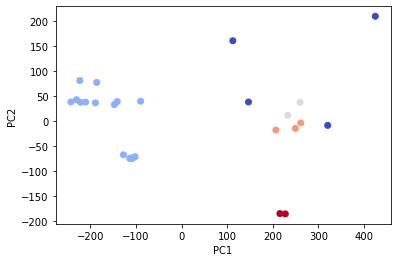

In [47]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
dbscan = DBSCAN(eps=150, min_samples=2)
#X = StandardScaler().fit_transform(X)
pca = PCA(n_components=10)
X = list(df_out['partitioned'].values)
processed = pca.fit_transform(X)
clusters = dbscan.fit_predict(processed)
plt.scatter(pcadf['PC1'], pcadf['PC2'], c=clusters, cmap='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [49]:
df_out['cluster'] = clusters
df_out['PC1'] = pcadf['PC1']
df_out['PC2'] = pcadf['PC2']
# for each cluster, get the mean impute accuracy, as a new column 
df_out['cluster_mean'] = df_out.groupby('cluster')['impute_accuracy'].transform('mean')
# for each cluster, compute the confidence interval of the mean impute accuracy
df_out['cluster_std'] = df_out.groupby('cluster')['impute_accuracy'].transform('std')
df_out.sort_values(by='impute_accuracy', ascending=False)

,bins,distribution,partitioned,gpt,impute_accuracy,pareto,cluster,PC1,PC2,cluster_mean,cluster_std
7,"[0, 15, 25, 65, 101]","[0.0, 0.28515625, 0.6940104166666666, 0.020833...","[65.0, 65.0, 65.0, 25.0, 65.0, 65.0, 65.0, 65....",0.7,0.898438,1,-1,424.721178,209.219583,0.819010,0.073280
5,"[0, 25, 50, 75, 100]","[0.28515625, 0.5989583333333334, 0.11458333333...","[50.0, 50.0, 50.0, 25.0, 50.0, 50.0, 50.0, 50....",0.7,0.863281,0,-1,112.509354,160.350123,0.819010,0.073280
6,"[0, 30, 60, 90]","[0.515625, 0.4427083333333333, 0.0416666666666...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.4,0.826823,0,2,261.309372,-3.521510,0.819444,0.012780
9,"[0, 10, 30, 60, 80, 101]","[0.0, 0.515625, 0.4427083333333333, 0.04036458...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.7,0.826823,0,2,249.438144,-14.509353,0.819444,0.012780
10,"[0.0, 29.0, 59.0]","[0.4778645833333333, 0.48046875]","[59.0, 59.0, 59.0, 29.0, 59.0, 59.0, 59.0, 59....",0.2,0.804688,0,2,206.862569,-17.694476,0.819444,0.012780
12,"[0.0, 25.0, 35.0, 59.0]","[0.28515625, 0.3502604166666667, 0.32291666666...","[59.0, 35.0, 59.0, 25.0, 35.0, 35.0, 59.0, 59....",0.2,0.766927,0,-1,146.814873,38.222394,0.819010,0.073280
4,"[0, 20, 40, 60, 80, 100]","[0.0, 0.73046875, 0.22786458333333334, 0.04036...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.9,0.765625,1,1,233.015089,11.672038,0.765625,0.000000
8,"[0, 3, 40, 60, 101]","[0.0, 0.73046875, 0.22786458333333334, 0.04166...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.3,0.765625,0,1,260.009629,37.666475,0.765625,0.000000
3,"[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]","[0.0, 0.0, 0.515625, 0.21484375, 0.15364583333...","[50.0, 40.0, 40.0, 30.0, 40.0, 30.0, 40.0, 40....",0.8,0.761719,0,0,-89.643335,39.816812,0.707491,0.022837
0,"[0, 19, 45, 65, 85, 100]","[0.0, 0.8268229166666666, 0.15234375, 0.020833...","[65.0, 45.0, 65.0, 45.0, 45.0, 45.0, 65.0, 65....",1.0,0.747396,1,-1,320.505809,-8.336105,0.819010,0.073280


In [51]:
import hdbscan

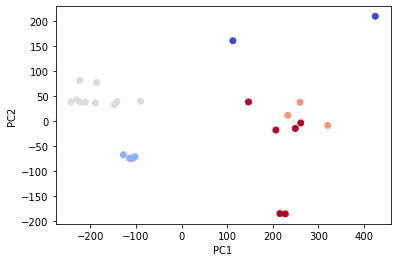

In [63]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
pca = PCA(n_components=20)
X = list(df_out['partitioned'].values)
processed = pca.fit_transform(X)
hdbscan_clusters = clusterer.fit_predict(processed)
plt.scatter(pcadf['PC1'], pcadf['PC2'], c=hdbscan_clusters, cmap='coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [64]:
df_out['cluster'] = hdbscan_clusters
df_out['PC1'] = pcadf['PC1']
df_out['PC2'] = pcadf['PC2']
# for each cluster, get the mean impute accuracy, as a new column 
df_out['cluster_mean'] = df_out.groupby('cluster')['impute_accuracy'].transform('mean')
# for each cluster, compute the confidence interval of the mean impute accuracy
df_out['cluster_std'] = df_out.groupby('cluster')['impute_accuracy'].transform('std')
df_out.sort_values(by='impute_accuracy', ascending=False)

,bins,distribution,partitioned,gpt,impute_accuracy,pareto,cluster,PC1,PC2,cluster_mean,cluster_std
7,"[0, 15, 25, 65, 101]","[0.0, 0.28515625, 0.6940104166666666, 0.020833...","[65.0, 65.0, 65.0, 25.0, 65.0, 65.0, 65.0, 65....",0.7,0.898438,1,-1,424.721178,209.219583,0.880859,0.024859
5,"[0, 25, 50, 75, 100]","[0.28515625, 0.5989583333333334, 0.11458333333...","[50.0, 50.0, 50.0, 25.0, 50.0, 50.0, 50.0, 50....",0.7,0.863281,0,-1,112.509354,160.350123,0.880859,0.024859
6,"[0, 30, 60, 90]","[0.515625, 0.4427083333333333, 0.0416666666666...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.4,0.826823,0,3,261.309372,-3.521510,0.783203,0.041965
9,"[0, 10, 30, 60, 80, 101]","[0.0, 0.515625, 0.4427083333333333, 0.04036458...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.7,0.826823,0,3,249.438144,-14.509353,0.783203,0.041965
10,"[0.0, 29.0, 59.0]","[0.4778645833333333, 0.48046875]","[59.0, 59.0, 59.0, 29.0, 59.0, 59.0, 59.0, 59....",0.2,0.804688,0,3,206.862569,-17.694476,0.783203,0.041965
12,"[0.0, 25.0, 35.0, 59.0]","[0.28515625, 0.3502604166666667, 0.32291666666...","[59.0, 35.0, 59.0, 25.0, 35.0, 35.0, 59.0, 59....",0.2,0.766927,0,3,146.814873,38.222394,0.783203,0.041965
4,"[0, 20, 40, 60, 80, 100]","[0.0, 0.73046875, 0.22786458333333334, 0.04036...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.9,0.765625,1,2,233.015089,11.672038,0.759549,0.010525
8,"[0, 3, 40, 60, 101]","[0.0, 0.73046875, 0.22786458333333334, 0.04166...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.3,0.765625,0,2,260.009629,37.666475,0.759549,0.010525
3,"[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]","[0.0, 0.0, 0.515625, 0.21484375, 0.15364583333...","[50.0, 40.0, 40.0, 30.0, 40.0, 30.0, 40.0, 40....",0.8,0.761719,0,1,-89.643335,39.816812,0.721745,0.018374
0,"[0, 19, 45, 65, 85, 100]","[0.0, 0.8268229166666666, 0.15234375, 0.020833...","[65.0, 45.0, 65.0, 45.0, 45.0, 45.0, 65.0, 65....",1.0,0.747396,1,2,320.505809,-8.336105,0.759549,0.010525


In [98]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [113]:
label_encoder = LabelEncoder()
true_label_names = df_out['truth'].values
true_labels = label_encoder.fit_transform(true_label_names)
n_clusters = len(label_encoder.classes_)

In [114]:
# get partitioned data as a two dimensional array
partitioned = np.array(df_out['partitioned'].values.tolist())
# run Kmeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(partitioned)
# get cluster labels, and add to the dataframe
df_out['cluster'] = kmeans.labels_
# evaluate clustering
silhouette = silhouette_score(partitioned, kmeans.labels_)
ari = adjusted_rand_score(true_labels, kmeans.labels_)
print(f"Silhouette: {silhouette}, ARI: {ari}")

Silhouette: 0.39371328841153547, ARI: 0.6069929531364319


In [103]:
# dictionary to dataframe
df_out = pd.DataFrame(outs)
# order by impute accuracy
df_out = df_out.sort_values(by='impute_accuracy', ascending=False)
df_out.to_csv(os.path.join(ppath, 'scratch/age_partitions.csv'), index=False)
# bin impute accuracy
df_out['cluster'] = pd.cut(df_out['impute_accuracy'], bins=[0, 0.7, 0.75, 0.8, 0.85, 0.9], labels=['0-0.7', '0.7-0.75', '0.75-0.8', '0.8-0.85', '0.85-0.9'])
df_out.to_csv(os.path.join(ppath, 'scratch/age_partitions.csv'), index=False)

In [116]:
# sort by impute accuracy
df_out = df_out.sort_values(by='impute_accuracy', ascending=False)
df_out.to_csv(os.path.join(ppath, 'scratch/age_partitions.kmeans.20240721.csv'), index=False)
df_out

,bins,distribution,partitioned,gpt,impute_accuracy,truth,cluster
7,"[0, 15, 25, 65, 101]","[0.0, 0.28515625, 0.6940104166666666, 0.020833...","[65.0, 65.0, 65.0, 25.0, 65.0, 65.0, 65.0, 65....",0.7,0.898438,0.85-0.9,4
5,"[0, 25, 50, 75, 100]","[0.28515625, 0.5989583333333334, 0.11458333333...","[50.0, 50.0, 50.0, 25.0, 50.0, 50.0, 50.0, 50....",0.7,0.863281,0.85-0.9,4
6,"[0, 30, 60, 90]","[0.515625, 0.4427083333333333, 0.0416666666666...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.4,0.826823,0.8-0.85,2
9,"[0, 10, 30, 60, 80, 101]","[0.0, 0.515625, 0.4427083333333333, 0.04036458...","[60.0, 60.0, 60.0, 30.0, 60.0, 30.0, 60.0, 60....",0.7,0.826823,0.8-0.85,2
10,"[0.0, 29.0, 59.0]","[0.4778645833333333, 0.48046875]","[59.0, 59.0, 59.0, 29.0, 59.0, 59.0, 59.0, 59....",0.2,0.804688,0.8-0.85,2
12,"[0.0, 25.0, 35.0, 59.0]","[0.28515625, 0.3502604166666667, 0.32291666666...","[59.0, 35.0, 59.0, 25.0, 35.0, 35.0, 59.0, 59....",0.2,0.766927,0.75-0.8,2
4,"[0, 20, 40, 60, 80, 100]","[0.0, 0.73046875, 0.22786458333333334, 0.04036...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.9,0.765625,0.75-0.8,0
8,"[0, 3, 40, 60, 101]","[0.0, 0.73046875, 0.22786458333333334, 0.04166...","[60.0, 40.0, 60.0, 40.0, 40.0, 40.0, 60.0, 60....",0.3,0.765625,0.75-0.8,0
3,"[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]","[0.0, 0.0, 0.515625, 0.21484375, 0.15364583333...","[50.0, 40.0, 40.0, 30.0, 40.0, 30.0, 40.0, 40....",0.8,0.761719,0.75-0.8,1
0,"[0, 19, 45, 65, 85, 100]","[0.0, 0.8268229166666666, 0.15234375, 0.020833...","[65.0, 45.0, 65.0, 45.0, 45.0, 45.0, 65.0, 65....",1.0,0.747396,0.7-0.75,0


In [47]:
df_out.groupby('cluster').size()

cluster
0-0.7        7
0.7-0.75    12
0.75-0.8     4
0.8-0.85     3
0.85-0.9     2
dtype: int64

In [79]:
i = [0.,         0.28515625, 0.69401042, 0.02083333]
j = [[0.28515625, 0.59895833, 0.11458333, 0.00130208],
     [0.,         0.515625,   0.44270833, 0.04036458, 0.00130208],
     [0.515625,   0.44270833, 0.04166667]]

print(wasserstein_distance(i, j[0]), wasserstein_distance(i, j[1]), wasserstein_distance(i, j[2]))
print(wasserstein_distance(j[2], j[1]))

print(wasserstein_distance(i, j[0],i, j[0]), wasserstein_distance(i, j[1],i, j[1]), wasserstein_distance(i, j[2],i, j[2]))
print(wasserstein_distance(j[2], j[1],j[2], j[1]))

0.047526042500000004 0.101302084 0.17252604333333335
0.13333333533333333
0.11386447954545764 0.18395996317599825 0.183959964375
0.00010512046166308608


In [67]:
from scipy.optimize import minimize

minimize(wasserstein_distance, j[0], args=(i, j[1]),method='Nelder-Mead')

ValueError: Value and weight array-likes for the same empirical distribution must be of the same size.

In [40]:
d1 = []
d2 = []
d3 = []
for i in range(len(outs)):
    d1.append(wasserstein_distance(outs[0]['distribution'], outs[i]['distribution']))
    d2.append(abs(outs[0]['impute_accuracy'] - outs[i]['impute_accuracy']))
    d3.append(outs[0]['gpt'] - outs[i]['gpt'])
    #print(outs[i]['bins'], d[-1])

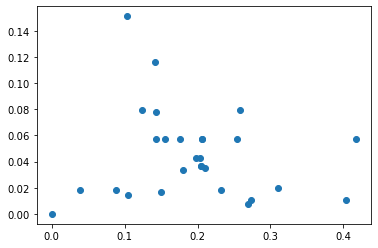

In [41]:
plt.plot(d1, d2, 'o')

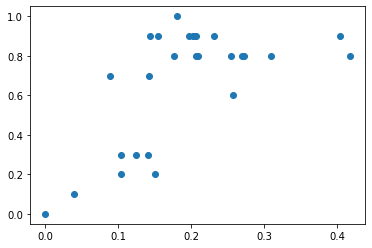

In [39]:
plt.plot(d1, d3, 'o')

ValueError: Input samples 'x' and 'y' should have the same last dimension.